<img src = "https://github.com/singlestore-labs/spaces-notebooks/blob/e551e274bb67bb1e5081131ee1150cdba713fc43/common/images/singlestore-jupyter.png?raw=true">

<div id="singlestore-header" style="display: flex; background-color: rgba(235, 249, 245, 0.25); padding: 5px;">
    <div id="icon-image" style="width: 90px; height: 90px;">
        <img width="100%" height="100%" src="https://raw.githubusercontent.com/singlestore-labs/spaces-notebooks/master/common/images/header-icons/browser.png" />
    </div>
    <div id="text" style="padding: 5px; margin-left: 10px;">
        <div id="badge" style="display: inline-block; background-color: rgba(0, 0, 0, 0.15); border-radius: 4px; padding: 4px 8px; align-items: center; margin-top: 6px; margin-bottom: -2px; font-size: 80%">SingleStore Notebooks</div>
        <h1 style="font-weight: 500; margin: 8px 0 0 4px;">Using ANN for Vector Search at Speed & Scale</h1>
    </div>
</div>

# Setup

In [4]:
!pip cache purge --quiet
!pip install tensorflow[and-cuda] --quiet
!pip install matplotlib --quiet

In [5]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from tensorflow import keras
from keras.datasets import fashion_mnist

import matplotlib.pyplot as plt
import numpy as np

In [6]:
import tensorflow as tf

if tf.test.gpu_device_name():
    print("GPU is available")
else:
    print("GPU is NOT available")

GPU is NOT available


In [7]:
physical_devices = tf.config.list_physical_devices("GPU")
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("Tensorflow is using GPU")
else:
    print("Tensorflow is NOT using GPU")

Tensorflow is NOT using GPU


# Load the Data

In [8]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [9]:
print("train_images: " + str(train_images.shape))
print("train_labels: " + str(train_labels.shape))
print("test_images:  " + str(test_images.shape))
print("test_labels:  " + str(test_labels.shape))

train_images: (60000, 28, 28)
train_labels: (60000,)
test_images:  (10000, 28, 28)
test_labels:  (10000,)


In [10]:
print(train_images[0])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0
    0   1   4   0   0   0   0   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62
   54   0   0   0   1   3   4   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134
  144 123  23   0   0   0   0  12  10   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 155 236 207 178
  107 156 161 109  64  23  77 130  72  15]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216
  216 163 127 121 122 146 141  88 172  66]
 [  0   0   0   0   0   0   0   0   0   1   1   1   0 200 232 23

In [11]:
print(train_labels[0])

9


# Visualise the Data

In [12]:
classes = [
    "t_shirt_top",
    "trouser",
    "pullover",
    "dress",
    "coat",
    "sandal",
    "shirt",
    "sneaker",
    "bag",
    "ankle_boot"
]

Text(0.5, 1.0, 'ankle_boot')

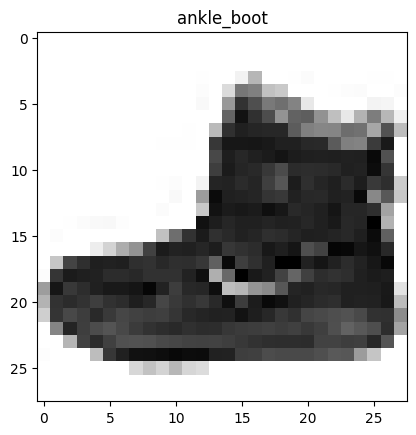

In [13]:
ax = plt.subplot(1, 1, 1)
plt.imshow(
    train_images[0],
    cmap = plt.cm.binary
)
ax.set_title(classes[train_labels[0]])

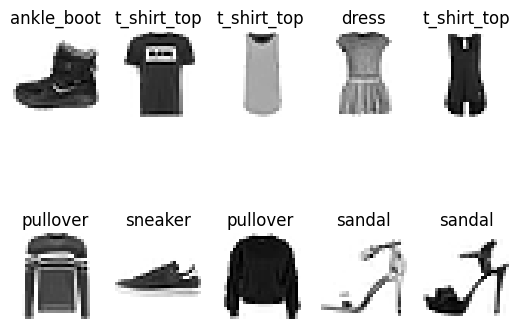

In [14]:
num_classes = len(classes)

for i in range(num_classes):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(
        np.column_stack(train_images[i].reshape(1, 28, 28)),
        cmap = plt.cm.binary
    )
    plt.axis("off")
    ax.set_title(classes[train_labels[i]])

# Prepare the Data

In [15]:
train_images = train_images.reshape((train_images.shape[0], -1))
test_images = test_images.reshape((test_images.shape[0], -1))

In [16]:
print("train_images: " + str(train_images.shape))
print("test_images:  " + str(test_images.shape))

train_images: (60000, 784)
test_images:  (10000, 784)


In [17]:
import pandas as pd

train_data_df = pd.DataFrame([
    (i,
     image.astype(int).tolist(),
     classes[int(label)],
    ) for i, (image, label) in enumerate(zip(train_images, train_labels))
], columns = ["idx", "img", "label"])

test_data_df = pd.DataFrame([
    (i,
     image.astype(int).tolist(),
     classes[int(label)],
    ) for i, (image, label) in enumerate(zip(test_images, test_labels))
], columns = ["idx", "img", "label"])

In [18]:
train_data_df.head()

idx                                                img        label
0    0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   ankle_boot
1    1  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 41, 188, 103, 5...  t_shirt_top
2    2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 22, 118, 24, 0, 0,...  t_shirt_top
3    3  [0, 0, 0, 0, 0, 0, 0, 0, 33, 96, 175, 156, 64,...        dress
4    4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  t_shirt_top

In [19]:
test_data_df.head()

idx                                                img       label
0    0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  ankle_boot
1    1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 67, 0, 0, 0...    pullover
2    2  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 67, 177, 129, 1...     trouser
3    3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 21, 123, 108, 99, ...     trouser
4    4  [0, 0, 0, 2, 0, 1, 1, 0, 0, 0, 0, 57, 67, 73, ...       shirt

In [20]:
train_data_df["vector"] = train_data_df["img"].apply(str)
test_data_df["vector"] = test_data_df["img"].apply(str)

In [21]:
train_data_df.head()

idx                                                img        label  \
0    0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   ankle_boot   
1    1  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 41, 188, 103, 5...  t_shirt_top   
2    2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 22, 118, 24, 0, 0,...  t_shirt_top   
3    3  [0, 0, 0, 0, 0, 0, 0, 0, 33, 96, 175, 156, 64,...        dress   
4    4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  t_shirt_top   

                                              vector  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 41, 188, 103, 5...  
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 22, 118, 24, 0, 0,...  
3  [0, 0, 0, 0, 0, 0, 0, 0, 33, 96, 175, 156, 64,...  
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

In [22]:
test_data_df.head()

idx                                                img       label  \
0    0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  ankle_boot   
1    1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 67, 0, 0, 0...    pullover   
2    2  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 67, 177, 129, 1...     trouser   
3    3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 21, 123, 108, 99, ...     trouser   
4    4  [0, 0, 0, 2, 0, 1, 1, 0, 0, 0, 0, 57, 67, 73, ...       shirt   

                                              vector  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 67, 0, 0, 0...  
2  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 67, 177, 129, 1...  
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 21, 123, 108, 99, ...  
4  [0, 0, 0, 2, 0, 1, 1, 0, 0, 0, 0, 57, 67, 73, ...

In [23]:
train_data_df.drop("img", axis = 1, inplace = True)
test_data_df.drop("img", axis = 1, inplace = True)

# Connect to the Database

In [24]:
from sqlalchemy import *

db_connection = create_engine(connection_url)

# Drop the Tables

In [25]:
%%sql
DROP TABLE IF EXISTS train_data_vec;
DROP TABLE IF EXISTS test_data_vec;

++
||
++
++

# Create the Tables

In [26]:
%%sql
CREATE TABLE IF NOT EXISTS train_data_vec (
     idx INT(10) UNSIGNED NOT NULL,
     label VARCHAR(20),
     vector VECTOR(784) NOT NULL,
     KEY(idx)
);

CREATE TABLE IF NOT EXISTS test_data_vec (
     idx INT(10) UNSIGNED NOT NULL,
     label VARCHAR(20),
     vector VECTOR(784) NOT NULL,
     KEY(idx)
);

++
||
++
++

# Write the Dataframes

In [27]:
train_data_df.to_sql(
    "train_data_vec",
    con = db_connection,
    if_exists = "append",
    index = False,
    chunksize = 1000
)

60000

In [28]:
test_data_df.to_sql(
    "test_data_vec",
    con = db_connection,
    if_exists = "append",
    index = False,
    chunksize = 1000
)

10000

# Read Back Some Data

In [29]:
train_df = pd.read_sql(
    "SELECT * FROM train_data_vec LIMIT 1",
    con = db_connection
)

In [30]:
import ast

train_df["vector"] = train_df["vector"].apply(ast.literal_eval).apply(np.array)

# Visualise the Data

Text(0.5, 1.0, 'dress')

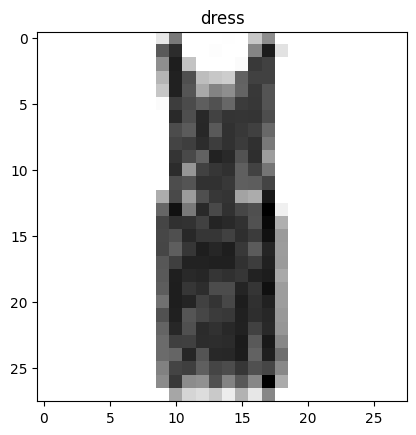

In [31]:
ax = plt.subplot(1, 1, 1)
plt.imshow(
    train_df["vector"].iloc[0].reshape(28, 28),
    cmap = plt.cm.binary
)
ax.set_title(train_df["label"].iloc[0])

# Create Vector Index

In [32]:
%%sql
ALTER TABLE train_data_vec ADD VECTOR INDEX (vector)
     INDEX_OPTIONS '{
          "index_type":"AUTO",
          "metric_type":"EUCLIDEAN_DISTANCE"
     }';

++
||
++
++

# Query Train Data without Index

In [33]:
%%sql
SELECT label, vector <-> (
    SELECT vector
    FROM train_data_vec
    WHERE idx = 30000) AS score
FROM train_data_vec
ORDER BY score USE INDEX ()
LIMIT 5;

+-------+-------------------+
| label |       score       |
+-------+-------------------+
| dress |        0.0        |
| dress | 570.5322076798119 |
| dress | 612.5422434412177 |
| dress | 653.6390441214478 |
| dress | 665.1052548281363 |
+-------+-------------------+

# Query Test Data without Index

In [34]:
%%sql
SELECT label, vector <-> (
    SELECT vector
    FROM test_data_vec
    WHERE idx = 500) AS score
FROM train_data_vec
ORDER BY score USE INDEX ()
LIMIT 5;

+----------+--------------------+
|  label   |       score        |
+----------+--------------------+
| pullover |  1211.59399140141  |
| pullover | 1295.9332544541019 |
| pullover | 1316.508640305866  |
| pullover |  1320.24278070361  |
| pullover | 1346.3539653449236 |
+----------+--------------------+

# Query Train Data with Index

In [35]:
%%sql
SELECT label, vector <-> (
    SELECT vector
    FROM train_data_vec
    WHERE idx = 30000) AS score
FROM train_data_vec
ORDER BY score
LIMIT 5;

+-------+-------------------+
| label |       score       |
+-------+-------------------+
| dress |        0.0        |
| dress | 570.5322076798119 |
| dress | 612.5422434412177 |
| dress | 653.6390441214478 |
| dress | 690.4375424323333 |
+-------+-------------------+

# Query Test Data with Index

In [36]:
%%sql
SELECT label, vector <-> (
    SELECT vector
    FROM test_data_vec
    WHERE idx = 500) AS score
FROM train_data_vec
ORDER BY score
LIMIT 5;

+----------+--------------------+
|  label   |       score        |
+----------+--------------------+
| pullover |  1211.59399140141  |
| pullover | 1295.9332544541019 |
| pullover | 1316.508640305866  |
| pullover | 1358.929725924045  |
|  shirt   | 1366.6458941510782 |
+----------+--------------------+

# Bonus: Using t-SNE with Plotly Express

In [37]:
!pip install scikit-learn --quiet

In [38]:
sample_size = 60000

<div class="alert alert-block alert-warning">
    <b class="fa fa-solid fa-exclamation-circle"></b>
    <div>
        <p><b>WARNING</b></p>
        <p>Running the following code cell may take a while.</p>
    </div>
</div>

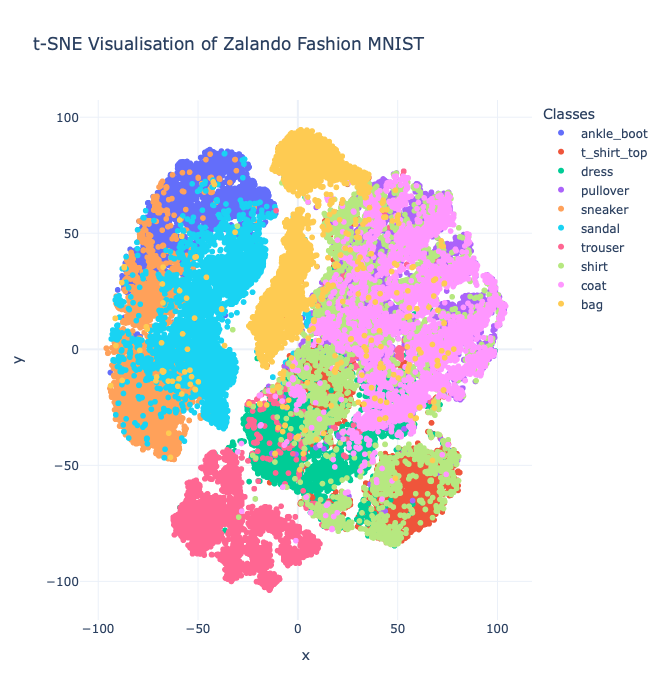

In [39]:
import numpy as np
import plotly.express as px
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder

# Convert numeric labels to string labels using the mapping
string_train_labels = [classes[label] for label in train_labels]

# Convert string labels to numerical values using LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(string_train_labels[:sample_size])

# Apply t-SNE to reduce dimensionality
tsne = TSNE(n_components = 2, random_state = 42)
X_tsne = tsne.fit_transform(train_images[:sample_size])

# Create a new DataFrame with the t-SNE results and numerical labels
tsne_df = pd.DataFrame(
    data = X_tsne,
    columns = ["x", "y"]
)
tsne_df["label"] = y_encoded
tsne_df["class_name"] = label_encoder.inverse_transform(tsne_df["label"])

# Plot the t-SNE visualisation using Plotly Express
fig = px.scatter(
    tsne_df,
    x = "x",
    y = "y",
    render_mode = "webgl",
    color = "class_name",
    color_continuous_scale = "rainbow",
    labels = {"class_name": "Classes"},
    title = "t-SNE Visualisation of Zalando Fashion MNIST"
)

# Set aspect ratio to make the plot square
fig.update_layout(
    autosize = False,
    width = 700,
    height = 700,
)

fig.show()

# Bonus: Build a Model

In [40]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [41]:
print("train_images: " + str(train_images.shape))
print("test_images:  " + str(test_images.shape))

train_images: (60000, 28, 28)
test_images:  (10000, 28, 28)


In [42]:
train_images = train_images / 255.0
test_images = test_images / 255.0

In [43]:
model = keras.Sequential(
    layers = [
        keras.layers.Flatten(input_shape = (28, 28)),
        keras.layers.Dense(128, activation = "relu"),
        keras.layers.Dense(10, activation = "softmax")
    ]
)

model.compile(
    optimizer = "adam",
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101770 (397.54 KB)
Trainable params: 101770 (397.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [44]:
history = model.fit(
    train_images,
    train_labels,
    batch_size = 60,
    epochs = 10,
    validation_split = 0.2,
    verbose = 2
)

Epoch 1/10
800/800 - 5s - loss: 0.5417 - accuracy: 0.8126 - val_loss: 0.4387 - val_accuracy: 0.8497 - 5s/epoch - 7ms/step
Epoch 2/10
800/800 - 2s - loss: 0.3984 - accuracy: 0.8598 - val_loss: 0.3864 - val_accuracy: 0.8633 - 2s/epoch - 3ms/step
Epoch 3/10
800/800 - 3s - loss: 0.3580 - accuracy: 0.8720 - val_loss: 0.3690 - val_accuracy: 0.8678 - 3s/epoch - 4ms/step
Epoch 4/10
800/800 - 3s - loss: 0.3314 - accuracy: 0.8804 - val_loss: 0.3580 - val_accuracy: 0.8712 - 3s/epoch - 4ms/step
Epoch 5/10
800/800 - 3s - loss: 0.3107 - accuracy: 0.8869 - val_loss: 0.3363 - val_accuracy: 0.8813 - 3s/epoch - 3ms/step
Epoch 6/10
800/800 - 2s - loss: 0.2921 - accuracy: 0.8927 - val_loss: 0.3688 - val_accuracy: 0.8627 - 2s/epoch - 3ms/step
Epoch 7/10
800/800 - 2s - loss: 0.2822 - accuracy: 0.8973 - val_loss: 0.3263 - val_accuracy: 0.8832 - 2s/epoch - 3ms/step
Epoch 8/10
800/800 - 2s - loss: 0.2700 - accuracy: 0.9006 - val_loss: 0.3115 - val_accuracy: 0.8861 - 2s/epoch - 3ms/step
Epoch 9/10
800/800 - 2s 

In [45]:
(loss, accuracy) = model.evaluate(test_images, test_labels, verbose = 2)

313/313 - 1s - loss: 0.3466 - accuracy: 0.8773 - 576ms/epoch - 2ms/step


In [46]:
predictions = model.predict(test_images)

313/313 [==============================] - 0s 1ms/step


In [47]:
from sklearn.metrics import confusion_matrix
from keras import utils

cm = confusion_matrix(
    np.argmax(utils.to_categorical(test_labels, num_classes), axis = 1),
    np.argmax(predictions, axis = 1)
)

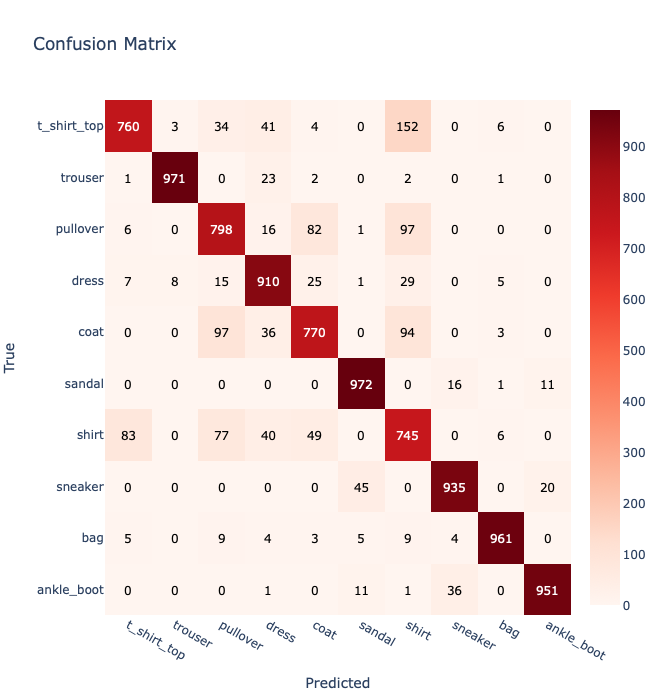

In [48]:
import plotly.graph_objects as go

data = go.Heatmap(
    z = cm[::-1],
    x = classes,
    y = classes[::-1].copy(),
    colorscale = "Reds"
)

annotations = []
thresh = cm.max() / 2

for i, row in enumerate(cm):
    for j, value in enumerate(row):
        annotations.append(
            {
                "x" : classes[j],
                "y" : classes[i],
                "font" : {"color" : "white" if value > thresh else "black"},
                "text" : str(value),
                "xref" : "x1",
                "yref" : "y1",
                "showarrow" : False
            }
        )

layout = {
    "title" : "Confusion Matrix",
    "xaxis" : {"title" : "Predicted"},
    "yaxis" : {"title" : "True"},
    "annotations" : annotations
}

fig = go.Figure(data = data, layout = layout)
fig.update_layout(
    height = 700,
    width = 700
)
fig.show()

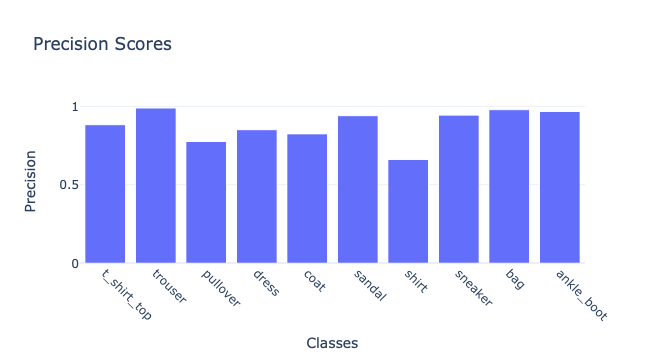

In [49]:
import plotly.express as px
from sklearn.metrics import precision_score

precision_scores = precision_score(
    np.argmax(utils.to_categorical(test_labels, num_classes), axis = 1),
    np.argmax(predictions, axis = 1),
    average = None
)

fig = px.bar(
    precision_scores,
    x = classes,
    y = precision_scores,
    labels = dict(x = "Classes", y = "Precision"),
    title = "Precision Scores"
)

fig.update_xaxes(tickangle = 45)
fig.show()

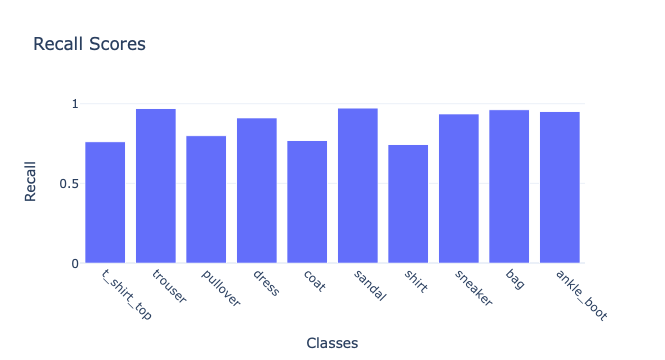

In [50]:
from sklearn.metrics import recall_score

recall_scores = recall_score(
    np.argmax(utils.to_categorical(test_labels, num_classes), axis = 1),
    np.argmax(predictions, axis = 1),
    average = None
)

fig = px.bar(
    recall_scores,
    x = classes,
    y = recall_scores,
    labels = dict(x = "Classes", y = "Recall"),
    title = "Recall Scores"
)

fig.update_xaxes(tickangle = 45)
fig.show()

# License
The MIT License (MIT) Copyright © [2017] Zalando SE, https://tech.zalando.com

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.